## Support Vector Machines - Part 2

#### Table of Contents

* [Preliminaries](#Preliminaries)
* [Null Model](#Null-Model)
* [Polynomial Kernel](#Polynomial-Kernel)
* [Gaussian Radial Basis Function Kernel](#Gaussian-Radial-Basis-Function-Kernel)
* [Comparison](#Comparison)

Takeaways from this script:

1. complex kernels are computationally difficult to omptimize
2. a linear kernel is a polynomial kernel

****
# Preliminaries
[TOP](#Support-Vector-Machines---Part-2)

Unlike the SVM1 lecture, we will be using the `SVC()` for the more flexible kernels.
We will be predicting the multi-class `urate_bin`.

In [1]:
# utilities
import numpy as np
import pandas as pd

# processing
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split

#algorithms
from sklearn.svm import SVC, LinearSVC

In [2]:
df = pd.read_pickle('C:/Users/hubst/Econ490_group/class_data.pkl')
df_prepped = df.drop(columns = 'year').join([
    pd.get_dummies(df['year'], drop_first = True)
]).set_index(['GeoName'], append = True)

**********
# Null Model 
[TOP](#Support-Vector-Machines---Part-1)

In [3]:
y = df_prepped['urate_bin']
x = df_prepped.drop(columns = 'urate_bin')
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size = 1e-2, 
                                                    random_state = 490)

x_train = x_train.apply(lambda j: (j - np.mean(j))/np.std(j))
x_test = x_test.apply(lambda j: (j - np.mean(j))/np.std(j))

In [4]:
yhat_null = y_train.value_counts().index[0]
acc_null = np.mean(yhat_null == y_test)
acc_null

0.43680731874420664

In [12]:
df_prepped

pct_d_rgdp urate_bin  pos_net_jobs  emp_estabs  \
fips  year GeoName                                                       
1001  2002 Autauga, AL    3.202147     lower             1   12.531208   
      2003 Autauga, AL    1.434404     lower             1   12.598415   
      2004 Autauga, AL   15.061365     lower             1   12.780078   
      2005 Autauga, AL    0.333105    higher             1   12.856784   
      2006 Autauga, AL    7.440034    higher             1   12.832506   
...                            ...       ...           ...         ...   
56045 2014 Weston, WY     2.055429     lower             1    8.410000   
      2015 Weston, WY    12.558802     lower             0    8.415385   
      2016 Weston, WY   -10.381257   similar             0    7.644231   
      2017 Weston, WY    -0.153371     lower             0    7.808081   
      2018 Weston, WY     7.624480     lower             0    8.074468   

                        estabs_entry_rate  estabs_exit_rate      pop  \
fips  year GeoName                                                     
1001  2002 Autauga, AL             11.268             9.256  45909.0   
      2003 Autauga, AL             10.603             9.940  46800.0   
      2004 Autauga, AL             11.140             8.519  48366.0   
      2005 Autauga, AL             11.735             8.673  49676.0   
      2006 Autauga, AL             10.645             8.766  51328.0   
...                                   ...               ...      ...   
56045 2014 Weston, WY               9.694             5.612   7138.0   
      2015 Weston, WY               6.076             8.608   7208.0   
      2016 Weston, WY              13.896             7.444   7220.0   
      2017 Weston, WY               5.941             9.901   6968.0   
      2018 Weston, WY               5.208             9.375   6924.0   

                        pop_pct_black  pop_pct_hisp       lfpr  ...  2009  \
fips  year GeoName                                              ...         
1001  2002 Autauga, AL      17.386569      1.611884  74.841638  ...     0   
      2003 Autauga, AL      17.493590      1.692308  75.093851  ...     0   
      2004 Autauga, AL      17.584667      1.796717  74.459624  ...     0   
      2005 Autauga, AL      17.612127      1.986875  74.920228  ...     0   
      2006 Autauga, AL      17.898613      2.032029  73.641001  ...     0   
...                               ...           ...        ...  ...   ...   
56045 2014 Weston, WY        1.204819      3.950686  87.627044  ...     0   
      2015 Weston, WY        1.054384      3.953940  86.978480  ...     0   
      2016 Weston, WY        1.038781      4.099723  87.816245  ...     0   
      2017 Weston, WY        1.248565      4.118829  87.065369  ...     0   
      2018 Weston, WY        1.299827      3.942808  89.519962  ...     0   

                        2010  2011  2012  2013  2014  2015  2016  2017  2018  
fips  year GeoName                                                            
1001  2002 Autauga, AL     0     0     0     0     0     0     0     0     0  
      2003 Autauga, AL     0     0     0     0     0     0     0     0     0  
      2004 Autauga, AL     0     0     0     0     0     0     0     0     0  
      2005 Autauga, AL     0     0     0     0     0     0     0     0     0  
      2006 Autauga, AL     0     0     0     0     0     0     0     0     0  
...                      ...   ...   ...   ...   ...   ...   ...   ...   ...  
56045 2014 Weston, WY      0     0     0     0     1     0     0     0     0  
      2015 Weston, WY      0     0     0     0     0     1     0     0     0  
      2016 Weston, WY      0     0     0     0     0     0     1     0     0  
      2017 Weston, WY      0     0     0     0     0     0     0     1     0  
      2018 Weston, WY      0     0     0     0     0     0     0     0     1  

[50127 rows x 27 columns]

*************
# Polynomial Kernel 
[TOP](#Support-Vector-Machines---Part-2)

Recall that the polynomial kernel adds two additional hyperparameters:

- `degree` - the degree of the polynomial kernel
- `coef0` - the progressive weight on larger terms

Here we are going to perform a grid search to identify the best value of these hyperparameters

In [5]:
%%time
param_grid = {'C': 10.**np.arange(-1, 4, step = 1),
              'degree': [1, 2],
              'coef0': 10.**np.arange(-2, 0, step = 1)
}

svmc_cv = SVC(kernel = 'poly')

grid_search = GridSearchCV(svmc_cv, param_grid, cv = 5,
                           scoring = 'accuracy').fit(x_train, y_train)

best = grid_search.best_params_
best

Wall time: 4.61 s


{'C': 100.0, 'coef0': 0.01, 'degree': 1}

How many models did we fit?

In [6]:
len(np.arange(-1, 4, step = 1))*2*len(np.arange(-2, 0, step = 1))*5

100

Print the model accuracy.

In [7]:
clf_poly = SVC(kernel = 'poly', C = best['C'], coef0 = best['coef0'],
               degree = best['degree']).fit(x_train, y_train)

In [8]:
%%time
param_grid  = {
   'C': 10.**np.linspace(-5, 2, num = 20), 
}

svmc_cv = LinearSVC(dual = False)

grid_search = GridSearchCV(svmc_cv, param_grid, cv = 5,
                           scoring = 'accuracy').fit(x_train, y_train)

best = grid_search.best_params_
best

Wall time: 952 ms


{'C': 0.00379269019073225}

In [9]:
svmc_poly = LinearSVC(dual = False, C = best['C']).fit(x_train, y_train)
acc_poly = svmc_poly.score(x_test, y_test)
acc_poly

0.6458308144924032

********
# Gaussian RBF Kernel
[TOP](#Support-Vector-Machines---Part-2)

Find the optimal values of `C` and `gamma` to the nearest magnitude ($10^n$)

In [10]:
%%time
param_grid  = {
   'C': 10.**np.arange(-1, 4, step = 1), 
    'gamma': 10.**np.arange(-7, -3, step = 1),
}

svmc_cv = SVC(kernel = 'rbf')

grid_search = GridSearchCV(svmc_cv, param_grid, cv = 5,
                           scoring = 'accuracy').fit(x_train, y_train)

best = grid_search.best_params_
best

Wall time: 1.14 s


{'C': 100.0, 'gamma': 0.0001}

How many models did we fit?

In [11]:
len(np.arange(-1, 4, step = 1))*len(np.arange(-7, -3, step = 1))*5

100

Refit the model on the full training data

In [47]:
clf_rbf = SVC(kernel = 'rbf', C = best['C'],
              gamma = best['gamma']).fit(x_train, y_train)
acc_rbf = clf_rbf.score(x_test, y_test)

Print the model accuracy. 

In [48]:
acc_rbf

0.6421432313706524

Is it better than the polynomial kernel?

Describe the tuned models flexibility and permitted margin violations

In [51]:
best

{'C': 100.0, 'gamma': 0.0001}

less flexible, more cranky

****
# Comparison
[TOP](#Support-Vector-Machines---Part-2)

Let's plot things this time.

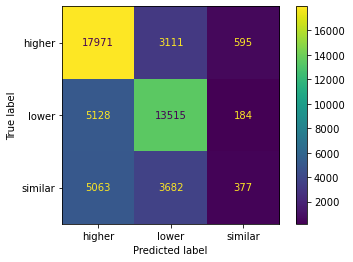

In [52]:
plot_confusion_matrix(clf_poly, x_test, y_test)

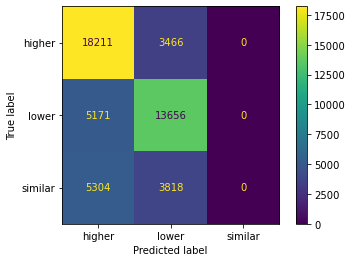

In [53]:
plot_confusion_matrix(clf_rbf, x_test, y_test)